<a href="https://colab.research.google.com/github/shrutij104/Celebal-Project/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install lifetimes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 8.6 MB/s eta 0:00:00


In [6]:
# Load your cleaned dataset

# Specify the sheet names you want to load
sheet_names = ['Year 2010-2011', 'Year 2009-2010']

# Create an empty list to store dataframes from each sheet
dfs = []

# Loop through the sheet names and load each one
for sheet in sheet_names:
    try:
        sheet_df = pd.read_excel('online_retail_II.xlsx', sheet_name=sheet)
        dfs.append(sheet_df)
        print(f"Sheet '{sheet}' loaded successfully.")
    except Exception as e:
        print(f"An error occurred while loading sheet '{sheet}': {e}")

# Concatenate all dataframes in the list
df = pd.concat(dfs, ignore_index=True)

# Perform initial cleaning steps on the combined dataframe
df.dropna(subset=['Customer ID'], inplace=True)
df = df[~df['Invoice'].astype(str).str.startswith('C')]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalPrice'] = df['Quantity'] * df['Price']
df = df[df['TotalPrice'] > 0]

print("\nCombined and cleaned data:")
display(df.head())
display(df.tail()) # Display last few rows to see data from the second sheet

Sheet 'Year 2010-2011' loaded successfully.
Sheet 'Year 2009-2010' loaded successfully.

Combined and cleaned data:


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
1067366,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom,5.90
1067367,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,3.75
1067368,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,3.75
1067369,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,7.50
1067370,538171,21931,JUMBO STORAGE BAG SUKI,2,2010-12-09 20:01:00,1.95,17530.0,United Kingdom,3.90


In [21]:
# Assuming summary_df_filtered is available from the previous CLV analysis

# --- Define High/Low Value Threshold and Create Target Variable ---
# Using quantiles of predicted_clv from the previous analysis
# Define the threshold for high value (e.g., top 25% or top 33%)
# Let's use the quantiles that defined your High-Value segment earlier
# The 'High-Value' segment corresponded to the top quantile based on predicted_clv
# We can recreate the quantile threshold or directly use the segment assignment

# Option 1: Recreate the quantile threshold (e.g., 75th percentile for top 25%)
# clv_threshold = summary_df_filtered['predicted_clv'].quantile(0.75)
# summary_df_filtered['IsHighValue'] = (summary_df_filtered['predicted_clv'] >= clv_threshold).astype(int)
# print(f"Defining high-value customers as those with predicted CLV >= {clv_threshold:.2f}")

# Option 2: Use the existing 'CLV_Segment' column (assuming 'High-Value' is the desired class)
summary_df_filtered['IsHighValue'] = (summary_df_filtered['CLV_Segment'] == 'High-Value').astype(int)
print("Defining high-value customers based on the 'High-Value' CLV Segment.")

print("\nDistribution of the target variable:")
display(summary_df_filtered['IsHighValue'].value_counts())
display(summary_df_filtered[['predicted_clv', 'CLV_Segment', 'IsHighValue']].head())

# Now summary_df_filtered has the 'IsHighValue' column as the target variable.
# We will use this DataFrame in the next parts of preparing the classification dataset.

Defining high-value customers based on the 'High-Value' CLV Segment.

Distribution of the target variable:


,count
IsHighValue,
0,2796
1,1406


,predicted_clv,CLV_Segment,IsHighValue
Customer ID,,,
12346.0,624.922792,High-Value,1
12347.0,130.127959,High-Value,1
12348.0,46.936731,Medium-Value,0
12349.0,60.083228,High-Value,1
12352.0,77.176614,High-Value,1


In [7]:
from lifetimes.utils import summary_data_from_transaction_data

# Generate the summary data required by the lifetimes library
# 'Customer ID': unique customer identifier
# 'InvoiceDate': transaction date
# 'TotalPrice': monetary value of the transaction (already calculated)
# Use '2011-12-10' as the observation_period_end, slightly after the last date in the 2010-2011 data
summary_df = summary_data_from_transaction_data(
    df,
    customer_id_col='Customer ID',
    datetime_col='InvoiceDate',
    monetary_value_col='TotalPrice',
    observation_period_end='2011-12-10'
)

print("Summary data (Recency, Frequency, T, MonetaryValue):")
display(summary_df.head())
display(summary_df.describe())

# Filter out customers with frequency 0 for Gamma-Gamma model (as per lifetimes documentation)
summary_df_filtered = summary_df[summary_df['frequency'] > 0]
print("\nSummary data for Gamma-Gamma model (frequency > 0):")
display(summary_df_filtered.head())
display(summary_df_filtered.describe())

Summary data (Recency, Frequency, T, MonetaryValue):


,frequency,recency,T,monetary_value
Customer ID,,,,
12346.0,7.0,400.0,726.0,11066.637143
12347.0,7.0,402.0,405.0,717.398571
12348.0,4.0,363.0,439.0,449.310000
12349.0,3.0,571.0,590.0,1120.056667
12350.0,0.0,0.0,311.0,0.000000


,frequency,recency,T,monetary_value
count,5878.000000,5878.000000,5878.000000,5878.000000
mean,4.632358,273.393671,475.260463,319.052041
std,9.999783,258.964160,223.090893,2256.846401
min,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,314.000000,0.000000
50%,2.000000,221.000000,531.000000,213.627500
75%,5.000000,512.000000,669.000000,376.209167
max,254.000000,738.000000,739.000000,168469.600000



Summary data for Gamma-Gamma model (frequency > 0):


,frequency,recency,T,monetary_value
Customer ID,,,,
12346.0,7.0,400.0,726.0,11066.637143
12347.0,7.0,402.0,405.0,717.398571
12348.0,4.0,363.0,439.0,449.310000
12349.0,3.0,571.0,590.0,1120.056667
12352.0,8.0,356.0,393.0,338.261250


,frequency,recency,T,monetary_value
count,4189.000000,4189.000000,4189.000000,4189.000000
mean,6.500119,383.625686,523.114347,447.693458
std,11.321654,227.619112,202.964113,2662.682020
min,1.000000,1.000000,10.000000,3.900000
25%,2.000000,176.000000,409.000000,191.650000
50%,3.000000,387.000000,590.000000,306.366000
75%,7.000000,592.000000,689.000000,452.715000
max,254.000000,738.000000,739.000000,168469.600000


In [8]:
from lifetimes import BetaGeoFitter, GammaGammaFitter

# Train the BG/NBD model
# The BG/NBD model estimates the number of future transactions
bgf = BetaGeoFitter(penalizer_coef=0.0) # You can experiment with penalizer_coef
bgf.fit(summary_df['frequency'], summary_df['recency'], summary_df['T'])

print("BG/NBD Model Training Summary:")
bgf.summary

# Train the Gamma-Gamma model
# The Gamma-Gamma model estimates the average monetary value of future transactions
ggf = GammaGammaFitter(penalizer_coef=0.0) # You can experiment with penalizer_coef

# Check if the assumptions for Gamma-Gamma model hold (optional but recommended)
# The monetary value of a customer's transactions varies independently from their transaction frequency.
# The monetary value follows a Gamma distribution.
# ggf.conditional_expected_average_profit(summary_df_filtered['frequency'], summary_df_filtered['monetary_value']).head()

ggf.fit(summary_df_filtered['frequency'], summary_df_filtered['monetary_value'])

print("\nGamma-Gamma Model Training Summary:")
ggf.summary

BG/NBD Model Training Summary:

Gamma-Gamma Model Training Summary:


,coef,se(coef),lower 95% bound,upper 95% bound
p,2.130350,0.104789,1.924963,2.335738
q,3.531424,0.112421,3.311079,3.751768
v,486.702266,37.162714,413.863347,559.541186


In [10]:
# Predict future transactions for the next 12 months
# You can adjust the time period (t) as needed
summary_df['predicted_purchases'] = bgf.predict(
    12, # Predict transactions in the next 12 time units (months, in this case)
    summary_df['frequency'],
    summary_df['recency'],
    summary_df['T']
)

print("Predicted future purchases (next 12 months):")
display(summary_df[['frequency', 'predicted_purchases']].head())

# Predict the average monetary value for customers with frequency > 0
summary_df_filtered['predicted_monetary_value'] = ggf.conditional_expected_average_profit(
    summary_df_filtered['frequency'],
    summary_df_filtered['monetary_value']
)

print("\nPredicted average monetary value for customers with frequency > 0:")
display(summary_df_filtered[['monetary_value', 'predicted_monetary_value']].head())

# Merge the predicted purchases into the filtered dataframe
summary_df_filtered = summary_df_filtered.merge(
    summary_df['predicted_purchases'],
    left_index=True,
    right_index=True,
    how='left'
)

# Estimate CLV for customers with frequency > 0
# CLV = Predicted Purchases * Predicted Average Monetary Value
summary_df_filtered['predicted_clv'] = summary_df_filtered['predicted_purchases'] * summary_df_filtered['predicted_monetary_value']

print("\nPredicted CLV for customers with frequency > 0:")
display(summary_df_filtered[['frequency', 'monetary_value', 'predicted_purchases', 'predicted_monetary_value', 'predicted_clv']].head())

# Note: For customers with frequency = 0, the Gamma-Gamma model is not applicable.
# Their predicted CLV would typically be considered low or require a different approach (e.g., a separate model for new customers).

Predicted future purchases (next 12 months):


,frequency,predicted_purchases
Customer ID,,
12346.0,7.0,0.065642
12347.0,7.0,0.193433
12348.0,4.0,0.106623
12349.0,3.0,0.065415
12350.0,0.0,0.021242



Predicted average monetary value for customers with frequency > 0:


,monetary_value,predicted_monetary_value
Customer ID,,
12346.0,11066.637143,9520.105774
12347.0,717.398571,672.729977
12348.0,449.310000,440.212990
12349.0,1120.056667,918.487960
12352.0,338.261250,347.485818



Predicted CLV for customers with frequency > 0:


,frequency,monetary_value,predicted_purchases,predicted_monetary_value,predicted_clv
Customer ID,,,,,
12346.0,7.0,11066.637143,0.065642,9520.105774,624.922792
12347.0,7.0,717.398571,0.193433,672.729977,130.127959
12348.0,4.0,449.310000,0.106623,440.212990,46.936731
12349.0,3.0,1120.056667,0.065415,918.487960,60.083228
12352.0,8.0,338.261250,0.222100,347.485818,77.176614


Evaluating BG/NBD Model:


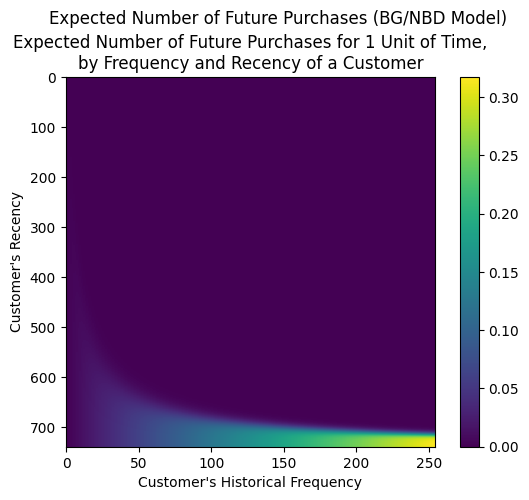

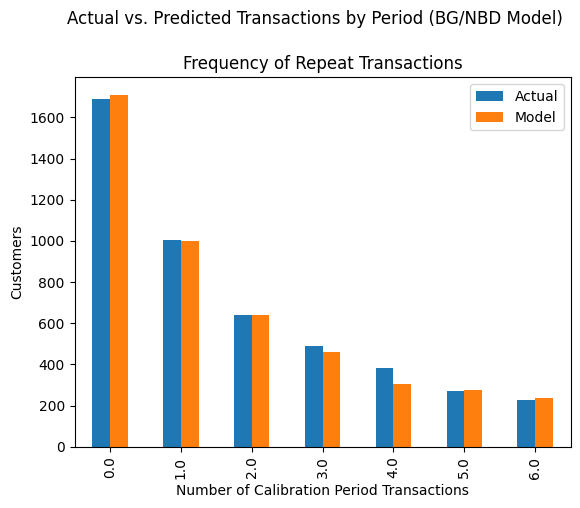


Evaluating Gamma-Gamma Model:
Correlation between frequency and monetary value (for customers with frequency > 0): 0.02
Assumption of independence between frequency and monetary value seems to hold.


In [13]:
from lifetimes.plotting import plot_frequency_recency_matrix, plot_period_transactions

# --- BG/NBD Model Evaluation ---

print("Evaluating BG/NBD Model:")

# Plot the frequency-recency matrix
# This plot shows the expected number of future transactions based on customer's recency and frequency
plot_frequency_recency_matrix(bgf)
plt.suptitle('Expected Number of Future Purchases (BG/NBD Model)', y=1.02)
plt.show()

# Plot the actual vs. predicted number of transactions by time period
# This helps to see if the model captures the overall trend of transactions over time
plot_period_transactions(bgf) # Removed t=12 argument
plt.suptitle('Actual vs. Predicted Transactions by Period (BG/NBD Model)', y=1.02)
plt.show()

# --- Gamma-Gamma Model Evaluation ---

print("\nEvaluating Gamma-Gamma Model:")

# Check the correlation between frequency and monetary value
# For the Gamma-Gamma model to be valid, there should be no correlation between these two.
correlation_rf = summary_df_filtered[['frequency', 'monetary_value']].corr().iloc[0, 1]
print(f"Correlation between frequency and monetary value (for customers with frequency > 0): {correlation_rf:.2f}")

# A correlation close to 0 (e.g., between -0.1 and 0.1) is generally considered acceptable.
if abs(correlation_rf) < 0.1:
    print("Assumption of independence between frequency and monetary value seems to hold.")
else:
    print("Warning: The correlation between frequency and monetary value is relatively high. Gamma-Gamma model assumptions might be violated.")

# You could also visualize the distribution of monetary values to see if it resembles a Gamma distribution.
# This is less critical than the independence assumption but can provide further insights.
# sns.histplot(summary_df_filtered['monetary_value'], kde=True)
# plt.title('Distribution of Monetary Value (for customers with frequency > 0)')
# plt.show()

In [14]:
# Define the number of segments
num_segments = 3

# Calculate quantiles
# We'll use qcut to divide customers into segments based on predicted_clv
# labels=False assigns integer labels to segments
summary_df_filtered['CLV_Segment_quantile'] = pd.qcut(
    summary_df_filtered['predicted_clv'],
    q=num_segments,
    labels=False,
    duplicates='drop' # Handle cases with duplicate CLV values
)

# Assign meaningful labels to the segments
# The labels are typically in ascending order of CLV
segment_labels = ['Low-Value', 'Medium-Value', 'High-Value']
summary_df_filtered['CLV_Segment'] = summary_df_filtered['CLV_Segment_quantile'].map(
    {i: label for i, label in enumerate(segment_labels[:summary_df_filtered['CLV_Segment_quantile'].nunique()])}
)


print("Customer Segmentation based on Predicted CLV:")
display(summary_df_filtered[['predicted_clv', 'CLV_Segment']].head())
display(summary_df_filtered['CLV_Segment'].value_counts())

# You can further analyze the characteristics of each segment
# For example, look at the average recency, frequency, and monetary value for each segment
print("\nCharacteristics of each CLV Segment:")
display(summary_df_filtered.groupby('CLV_Segment')[['frequency', 'recency', 'monetary_value', 'predicted_clv']].mean())

Customer Segmentation based on Predicted CLV:


,predicted_clv,CLV_Segment
Customer ID,,
12346.0,624.922792,High-Value
12347.0,130.127959,High-Value
12348.0,46.936731,Medium-Value
12349.0,60.083228,High-Value
12352.0,77.176614,High-Value


,count
CLV_Segment,
High-Value,1397
Medium-Value,1396
Low-Value,1396



Characteristics of each CLV Segment:


,frequency,recency,monetary_value,predicted_clv
CLV_Segment,,,,
High-Value,13.047244,469.465999,739.570603,170.019796
Low-Value,2.280086,274.545129,261.017012,10.376940
Medium-Value,4.168338,406.804441,342.283677,30.829743


In [15]:
# Assuming 'df' is your original DataFrame with 'Customer ID' and 'Country'
# Extract unique customer ID and their country
customer_country = df[['Customer ID', 'Country']].drop_duplicates().set_index('Customer ID')

# Merge country information into the summary_df_filtered
summary_df_filtered = summary_df_filtered.merge(
    customer_country,
    left_index=True,
    right_index=True,
    how='left'
)

print("Summary data with Country information:")
display(summary_df_filtered.head())

# Analyze the distribution of Country within each CLV Segment
print("\nDistribution of Country within each CLV Segment:")
display(pd.crosstab(summary_df_filtered['CLV_Segment'], summary_df_filtered['Country'], normalize='index'))

# You can also group by segment and country to see average CLV or other metrics
print("\nAverage predicted CLV by CLV Segment and Country (Top 5 Countries per Segment):")
clv_by_segment_country = summary_df_filtered.groupby(['CLV_Segment', 'Country'])['predicted_clv'].mean().reset_index()

# Display top N countries per segment by average CLV
top_n = 5
for segment in segment_labels:
    print(f"\n--- {segment} Segment ---")
    display(clv_by_segment_country[clv_by_segment_country['CLV_Segment'] == segment]
            .sort_values(by='predicted_clv', ascending=False)
            .head(top_n))

# If you had more demographic columns (e.g., 'Age Group', 'City'), you would repeat the merging and analysis steps for those columns.

Summary data with Country information:


,frequency,recency,T,monetary_value,predicted_monetary_value,predicted_purchases,predicted_clv,CLV_Segment_quantile,CLV_Segment,Country
Customer ID,,,,,,,,,,
12346.0,7.0,400.0,726.0,11066.637143,9520.105774,0.065642,624.922792,2,High-Value,United Kingdom
12347.0,7.0,402.0,405.0,717.398571,672.729977,0.193433,130.127959,2,High-Value,Iceland
12348.0,4.0,363.0,439.0,449.310000,440.212990,0.106623,46.936731,1,Medium-Value,Finland
12349.0,3.0,571.0,590.0,1120.056667,918.487960,0.065415,60.083228,2,High-Value,Italy
12352.0,8.0,356.0,393.0,338.261250,347.485818,0.222100,77.176614,2,High-Value,Norway



Distribution of Country within each CLV Segment:


Country,Australia,Austria,Bahrain,Belgium,Canada,Channel Islands,Cyprus,Czech Republic,Denmark,EIRE,...,Portugal,Singapore,Spain,Sweden,Switzerland,Thailand,USA,United Arab Emirates,United Kingdom,Unspecified
CLV_Segment,,,,,,,,,,,,,,,,,,,,,
High-Value,0.004267,0.002845,0.000000,0.008535,0.000711,0.004979,0.002845,0.000000,0.003556,0.002134,...,0.005690,0.000711,0.007824,0.002134,0.007112,0.000000,0.000711,0.00000,0.867710,0.000711
Low-Value,0.001432,0.002147,0.001432,0.002147,0.000716,0.001432,0.001432,0.000000,0.001432,0.000716,...,0.005011,0.000000,0.003579,0.002147,0.002147,0.000716,0.002147,0.00000,0.939871,0.000000
Medium-Value,0.001430,0.002859,0.000000,0.005718,0.000000,0.001430,0.000715,0.000715,0.002859,0.000000,...,0.002144,0.000000,0.007148,0.001430,0.005004,0.000000,0.000715,0.00143,0.919943,0.001430



Average predicted CLV by CLV Segment and Country (Top 5 Countries per Segment):

--- Low-Value Segment ---


,CLV_Segment,Country,predicted_clv
36,Low-Value,Finland,13.618559
43,Low-Value,Portugal,12.986010
30,Low-Value,Belgium,12.689851
34,Low-Value,Denmark,12.538639
46,Low-Value,Switzerland,12.510105



--- Medium-Value Segment ---


,CLV_Segment,Country,predicted_clv
65,Medium-Value,Lithuania,48.371090
57,Medium-Value,European Community,44.571390
73,Medium-Value,United Arab Emirates,42.864300
62,Medium-Value,Israel,42.769284
58,Medium-Value,Finland,38.269122



--- High-Value Segment ---


,CLV_Segment,Country,predicted_clv
16,High-Value,Netherlands,3921.244654
7,High-Value,EIRE,3064.062922
0,High-Value,Australia,533.296506
20,High-Value,Singapore,410.237124
22,High-Value,Sweden,291.100388


Visualizing Segment Characteristics:


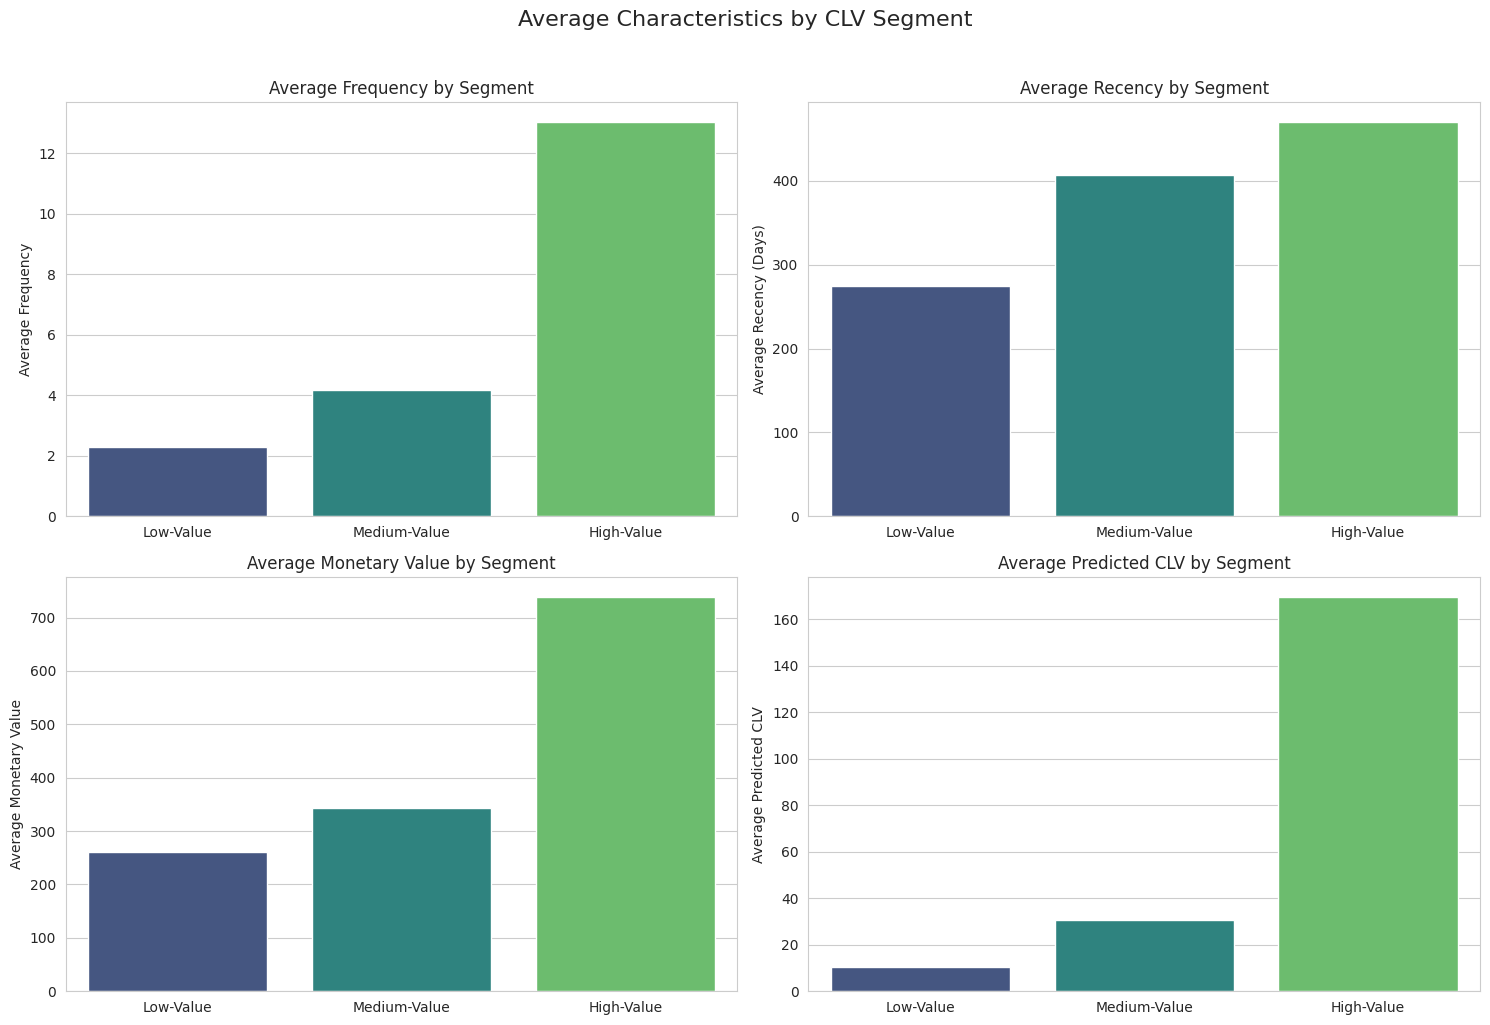


Distribution of Top Countries within each CLV Segment:


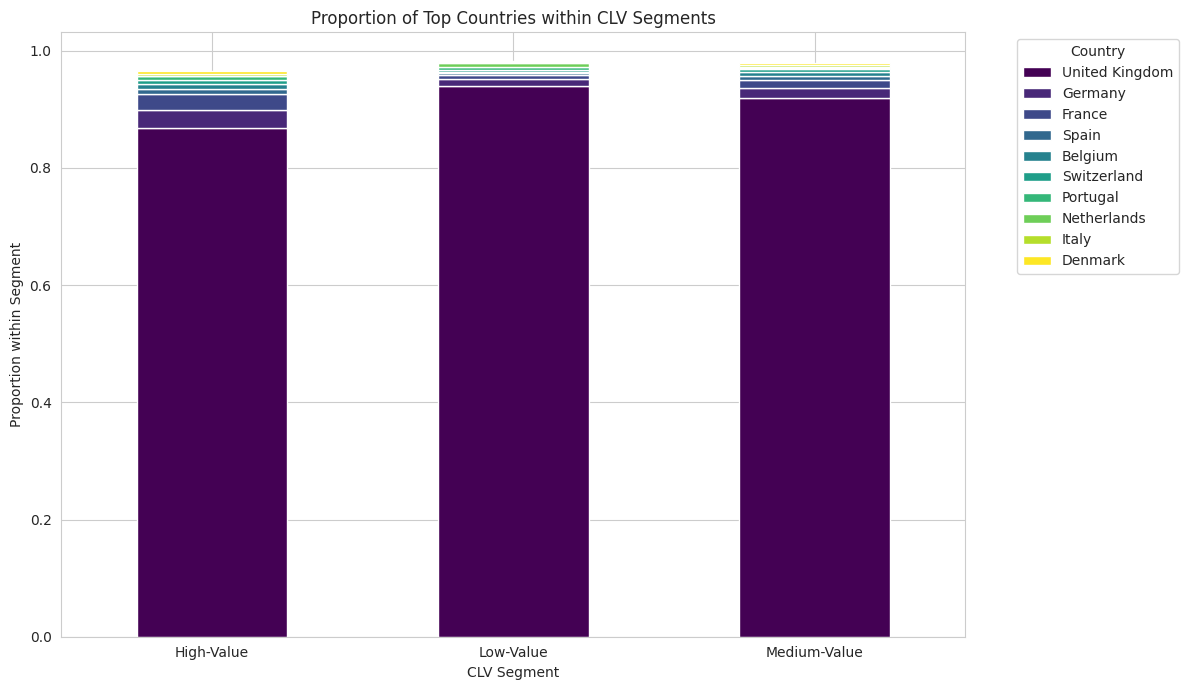

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a style for the plots
sns.set_style("whitegrid")

print("Visualizing Segment Characteristics:")

# --- Average RFM and Predicted CLV by Segment ---
segment_means = summary_df_filtered.groupby('CLV_Segment')[['frequency', 'recency', 'monetary_value', 'predicted_clv']].mean().reset_index()

# Define the order of segments for plotting
segment_order = ['Low-Value', 'Medium-Value', 'High-Value']
segment_means['CLV_Segment'] = pd.Categorical(segment_means['CLV_Segment'], categories=segment_order, ordered=True)
segment_means = segment_means.sort_values('CLV_Segment')


fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Average Characteristics by CLV Segment', y=1.02, fontsize=16)

sns.barplot(x='CLV_Segment', y='frequency', data=segment_means, ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Average Frequency by Segment')
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('Average Frequency')

sns.barplot(x='CLV_Segment', y='recency', data=segment_means, ax=axes[0, 1], palette='viridis')
axes[0, 1].set_title('Average Recency by Segment')
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('Average Recency (Days)')

sns.barplot(x='CLV_Segment', y='monetary_value', data=segment_means, ax=axes[1, 0], palette='viridis')
axes[1, 0].set_title('Average Monetary Value by Segment')
axes[1, 0].set_xlabel('')
axes[1, 0].set_ylabel('Average Monetary Value')

sns.barplot(x='CLV_Segment', y='predicted_clv', data=segment_means, ax=axes[1, 1], palette='viridis')
axes[1, 1].set_title('Average Predicted CLV by Segment')
axes[1, 1].set_xlabel('')
axes[1, 1].set_ylabel('Average Predicted CLV')

plt.tight_layout()
plt.show()

# --- Distribution of Country by Segment (Top N Countries) ---
print("\nDistribution of Top Countries within each CLV Segment:")

# Calculate the proportion of each country within each segment
country_segment_proportion = pd.crosstab(summary_df_filtered['CLV_Segment'], summary_df_filtered['Country'], normalize='index')

# Select top N countries overall or within each segment for visualization
# For simplicity, let's take the top 10 countries based on overall representation in the filtered data
top_countries = summary_df_filtered['Country'].value_counts().nlargest(10).index.tolist()

# Filter the proportion data for these top countries
country_segment_proportion_top = country_segment_proportion[top_countries]

# Plot the stacked bar chart
country_segment_proportion_top.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='viridis')
plt.title('Proportion of Top Countries within CLV Segments')
plt.xlabel('CLV Segment')
plt.ylabel('Proportion within Segment')
plt.xticks(rotation=0)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [18]:
# Install Streamlit and other necessary libraries
!pip install streamlit pandas matplotlib seaborn lifetimes openpyxl

In [20]:
# Prepare data for the dashboard
# Save the summary_df_filtered DataFrame to a CSV file
try:
    summary_df_filtered.to_csv('clv_summary_data.csv', index=True)
    print("Prepared data saved to 'clv_summary_data.csv'")
except Exception as e:
    print(f"An error occurred while saving the data: {e}")

Prepared data saved to 'clv_summary_data.csv'


In [22]:
# Assuming summary_df_filtered and IsHighValue column are available

# --- Select Features and Target Variable ---

# Define the features (X) - using RFM metrics and Country for now
# Note: Consider if using full-period RFM is appropriate for predicting *future* high value from *early* behavior.
# For a true prediction from early behavior, you'd calculate RFM over a fixed initial period.
features = ['frequency', 'recency', 'T', 'monetary_value', 'Country']

# Define the target variable (y)
target = 'IsHighValue'

# Create X (features DataFrame) and y (target Series)
X = summary_df_filtered[features].copy()
y = summary_df_filtered[target].copy()

print("Selected Features (X):")
display(X.head())

print("\nTarget Variable (y):")
display(y.head())

print(f"\nShape of feature data (X): {X.shape}")
print(f"Shape of target data (y): {y.shape}")

Selected Features (X):


,frequency,recency,T,monetary_value,Country
Customer ID,,,,,
12346.0,7.0,400.0,726.0,11066.637143,United Kingdom
12347.0,7.0,402.0,405.0,717.398571,Iceland
12348.0,4.0,363.0,439.0,449.310000,Finland
12349.0,3.0,571.0,590.0,1120.056667,Italy
12352.0,8.0,356.0,393.0,338.261250,Norway



Target Variable (y):


,IsHighValue
Customer ID,
12346.0,1
12347.0,1
12348.0,0
12349.0,1
12352.0,1



Shape of feature data (X): (4202, 5)
Shape of target data (y): (4202,)


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE # Uncomment if you need to handle class imbalance

# --- Data Preprocessing for Classification ---

# Identify numerical and categorical columns
numerical_features = ['frequency', 'recency', 'T', 'monetary_value']
categorical_features = ['Country'] # Assuming 'Country' is the only categorical feature

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore') # handle_unknown='ignore' is useful for unseen categories in test set

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep other columns (if any) - though we selected all relevant ones
)

# --- Split Data into Training and Testing Sets ---
# It's crucial to split *before* applying scaling or oversampling to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) # stratify=y helps maintain class distribution

print("Original X shape:", X.shape)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# --- Apply Preprocessing to Training and Testing Data ---
# The preprocessor is fitted only on the training data to avoid data leakage
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test) # Use transform, not fit_transform, on test data

# --- Handle Class Imbalance (Optional) ---
# Check class distribution: y_train.value_counts()
# If imbalance is significant, uncomment and use SMOTE or similar techniques
# print("\nClass distribution before handling imbalance (Training):")
# display(y_train.value_counts())

# smote = SMOTE(random_state=42)
# X_train_processed_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# print("\nClass distribution after handling imbalance (Training):")
# display(pd.Series(y_train_resampled).value_counts())

# For now, we proceed without explicit imbalance handling unless the distribution is very skewed.
# Use X_train_processed and y_train (or resampled versions if you uncommented SMOTE) for model training.

print("\nProcessed Training Data Shape:", X_train_processed.shape)
print("Processed Testing Data Shape:", X_test_processed.shape)

Original X shape: (4202, 5)
X_train shape: (3151, 5)
X_test shape: (1051, 5)
y_train shape: (3151,)
y_test shape: (1051,)

Processed Training Data Shape: (3151, 37)
Processed Testing Data Shape: (1051, 37)


In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# --- Model Selection and Training (Logistic Regression) ---

# Initialize the Logistic Regression model
# You can adjust parameters like C (regularization strength) and solver
model = LogisticRegression(random_state=42, solver='liblinear') # 'liblinear' is good for small datasets and binary classification

# Train the model
model.fit(X_train_processed, y_train)

print("Logistic Regression Model trained successfully!")

# --- Model Evaluation (on Training Set - preliminary) ---
# We will do a more thorough evaluation on the test set later,
# but a quick check on the training set can be informative.
y_train_pred = model.predict(X_train_processed)
y_train_prob = model.predict_proba(X_train_processed)[:, 1] # Probability of the positive class (1)

print("\nClassification Report (Training Set):")
print(classification_report(y_train, y_train_pred))

print("\nConfusion Matrix (Training Set):")
display(confusion_matrix(y_train, y_train_pred))

print("\nAUC Score (Training Set):")
print(roc_auc_score(y_train, y_train_prob))

Logistic Regression Model trained successfully!

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2097
           1       0.91      0.85      0.88      1054

    accuracy                           0.92      3151
   macro avg       0.92      0.90      0.91      3151
weighted avg       0.92      0.92      0.92      3151


Confusion Matrix (Training Set):


array([[2008,   89],
       [ 163,  891]])


AUC Score (Training Set):
0.9737177625215022


In [25]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# --- Model Evaluation (on Test Set) ---

print("Evaluating Logistic Regression Model on Test Set:")

# Make predictions on the test set
y_test_pred = model.predict(X_test_processed)
y_test_prob = model.predict_proba(X_test_processed)[:, 1] # Probability of the positive class (1)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

print("\nConfusion Matrix (Test Set):")
display(confusion_matrix(y_test, y_test_pred))

print("\nAUC Score (Test Set):")
print(roc_auc_score(y_test, y_test_prob))

# Optional: Plot ROC curve
# RocCurveDisplay.from_estimator(model, X_test_processed, y_test)
# plt.title('ROC Curve (Test Set)')
# plt.show()

Evaluating Logistic Regression Model on Test Set:

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       699
           1       0.91      0.85      0.88       352

    accuracy                           0.92      1051
   macro avg       0.92      0.91      0.91      1051
weighted avg       0.92      0.92      0.92      1051


Confusion Matrix (Test Set):


array([[670,  29],
       [ 52, 300]])


AUC Score (Test Set):
0.9784838730654182


In [26]:
# --- Define Cohort ---

# Find the first purchase date for each customer
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']) # Ensure InvoiceDate is datetime
first_purchase_date = df.groupby('Customer ID')['InvoiceDate'].min().reset_index()
first_purchase_date.rename(columns={'InvoiceDate': 'CohortMonth'}, inplace=True)

# Extract year and month to define the cohort (e.g., 'YYYY-MM')
first_purchase_date['CohortMonth'] = first_purchase_date['CohortMonth'].dt.to_period('M')

# Merge the CohortMonth back into the original DataFrame
df = df.merge(first_purchase_date, on='Customer ID', how='left')

print("DataFrame with CohortMonth added:")
display(df.head())
display(df.tail())
print("\nDistribution of customers by Cohort Month:")
display(df[['Customer ID', 'CohortMonth']].drop_duplicates().groupby('CohortMonth').count())

DataFrame with CohortMonth added:


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2009-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2009-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2009-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2009-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2009-12


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,CohortMonth
805544,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom,5.90,2009-12
805545,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,3.75,2009-12
805546,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,3.75,2009-12
805547,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,7.50,2009-12
805548,538171,21931,JUMBO STORAGE BAG SUKI,2,2010-12-09 20:01:00,1.95,17530.0,United Kingdom,3.90,2009-12



Distribution of customers by Cohort Month:


,Customer ID
CohortMonth,
2009-12,955
2010-01,383
2010-02,374
2010-03,443
2010-04,294
2010-05,254
2010-06,270
2010-07,186
2010-08,162


In [27]:
# --- Calculate Cohort Period ---

# Extract the month of each invoice
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')

# Calculate the difference in months between InvoiceMonth and CohortMonth
# This gives us the Cohort Period (e.g., 0 for the first month, 1 for the second, etc.)
df['CohortPeriod'] = (df['InvoiceMonth'] - df['CohortMonth']).apply(lambda x: x.n)

print("DataFrame with InvoiceMonth and CohortPeriod added:")
display(df.head())


# --- Group Data by Cohort and Period ---

# Group by CohortMonth and CohortPeriod and count unique customers
cohort_counts = df.groupby(['CohortMonth', 'CohortPeriod'])['Customer ID'].nunique().reset_index(name='CustomerCount')

print("\nCustomer counts by Cohort Month and Cohort Period:")
display(cohort_counts.head())
display(cohort_counts.tail())

# Optionally, group by CohortMonth and CohortPeriod and sum TotalPrice for monetary analysis
cohort_monetary = df.groupby(['CohortMonth', 'CohortPeriod'])['TotalPrice'].sum().reset_index(name='TotalRevenue')

print("\nTotal Revenue by Cohort Month and Cohort Period:")
display(cohort_monetary.head())
display(cohort_monetary.tail())

DataFrame with InvoiceMonth and CohortPeriod added:


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,CohortMonth,InvoiceMonth,CohortPeriod
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2009-12,2010-12,12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2009-12,2010-12,12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2009-12,2010-12,12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2009-12,2010-12,12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2009-12,2010-12,12



Customer counts by Cohort Month and Cohort Period:


,CohortMonth,CohortPeriod,CustomerCount
0,2009-12,0,955
1,2009-12,1,337
2,2009-12,2,319
3,2009-12,3,406
4,2009-12,4,363


,CohortMonth,CohortPeriod,CustomerCount
320,2011-10,1,71
321,2011-10,2,35
322,2011-11,0,191
323,2011-11,1,27
324,2011-12,0,28



Total Revenue by Cohort Month and Cohort Period:


,CohortMonth,CohortPeriod,TotalRevenue
0,2009-12,0,686654.160
1,2009-12,1,395425.571
2,2009-12,2,296802.132
3,2009-12,3,379654.490
4,2009-12,4,306885.820


,CohortMonth,CohortPeriod,TotalRevenue
320,2011-10,1,33768.66
321,2011-10,2,11052.57
322,2011-11,0,81260.19
323,2011-11,1,12868.97
324,2011-12,0,23844.09


In [28]:
# --- Pivot Data for Analysis ---

# Pivot the cohort_counts table to create a cohort matrix
cohort_matrix = cohort_counts.pivot_table(
    index='CohortMonth',
    columns='CohortPeriod',
    values='CustomerCount'
)

print("Pivoted Cohort Matrix (Customer Counts):")
display(cohort_matrix.head())
display(cohort_matrix.tail())

# You can also pivot the cohort_monetary data if you want to analyze revenue cohorts
cohort_monetary_matrix = cohort_monetary.pivot_table(
    index='CohortMonth',
    columns='CohortPeriod',
    values='TotalRevenue'
)

print("\nPivoted Cohort Monetary Matrix (Total Revenue):")
display(cohort_monetary_matrix.head())
display(cohort_monetary_matrix.tail())

Pivoted Cohort Matrix (Customer Counts):


CohortPeriod,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
CohortMonth,,,,,,,,,,,,,,,,,,,,,
2009-12,955.0,337.0,319.0,406.0,363.0,343.0,360.0,327.0,321.0,346.0,...,289.0,251.0,289.0,270.0,248.0,244.0,301.0,291.0,389.0,188.0
2010-01,383.0,79.0,119.0,117.0,101.0,115.0,99.0,88.0,107.0,122.0,...,58.0,90.0,76.0,71.0,75.0,93.0,74.0,94.0,22.0,NaN
2010-02,374.0,89.0,84.0,109.0,92.0,75.0,72.0,107.0,95.0,103.0,...,75.0,60.0,61.0,54.0,86.0,86.0,61.0,22.0,NaN,NaN
2010-03,443.0,84.0,102.0,107.0,103.0,90.0,109.0,134.0,122.0,48.0,...,75.0,77.0,69.0,78.0,89.0,94.0,35.0,NaN,NaN,NaN
2010-04,294.0,57.0,57.0,48.0,54.0,66.0,81.0,77.0,31.0,32.0,...,46.0,41.0,44.0,53.0,66.0,17.0,NaN,NaN,NaN,NaN


CohortPeriod,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
CohortMonth,,,,,,,,,,,,,,,,,,,,,
2011-08,106.0,29.0,33.0,28.0,18.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09,189.0,51.0,71.0,28.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-10,221.0,71.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11,191.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Pivoted Cohort Monetary Matrix (Total Revenue):


CohortPeriod,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
CohortMonth,,,,,,,,,,,,,,,,,,,,,
2009-12,686654.160,395425.571,296802.132,379654.490,306885.82,305953.89,302857.56,313502.730,332498.84,392636.02,...,256994.42,163344.301,286620.04,280293.63,254570.15,274325.52,376913.091,415966.24,448001.43,163891.22
2010-01,161893.491,39134.050,51120.260,57728.651,58860.36,61177.15,52107.80,48190.320,60603.94,74792.12,...,31078.22,49938.830,40971.45,47811.51,42713.24,59232.51,59964.440,58715.02,8825.86,NaN
2010-02,170434.884,33367.180,54886.300,53395.920,44024.54,39778.48,40163.19,51343.831,53038.30,54936.22,...,38057.69,30056.580,33408.22,25525.65,45506.54,46046.54,38698.170,11147.57,NaN,NaN
2010-03,235467.061,50007.690,51969.270,64790.790,50453.16,56065.12,65617.17,81628.970,76825.21,35244.78,...,31838.17,42854.240,50034.40,47470.24,57506.93,62626.44,17308.240,NaN,NaN,NaN
2010-04,125100.731,19036.350,20714.240,30117.850,22309.96,30846.57,35241.40,32775.000,15337.20,17697.92,...,22476.17,17874.390,19423.66,32172.93,30079.20,4942.97,NaN,NaN,NaN,NaN


CohortPeriod,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
CohortMonth,,,,,,,,,,,,,,,,,,,,,
2011-08,45060.08,18682.75,31427.93,40050.63,13965.72,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09,96518.24,20356.60,31425.96,10245.79,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-10,108727.69,33768.66,11052.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11,81260.19,12868.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12,23844.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# --- Calculate Retention Rate ---

# Get the size of the initial cohort (number of customers in period 0)
cohort_sizes = cohort_matrix.iloc[:, 0]

# Divide the cohort matrix by the cohort sizes to get retention rates
retention_matrix = cohort_matrix.divide(cohort_sizes, axis=0)

print("Cohort Retention Matrix:")
display(retention_matrix.head())
display(retention_matrix.tail())

# You could also calculate other metrics like average spending per customer in each period
# average_spending_matrix = cohort_monetary_matrix.divide(cohort_matrix, axis=0)
# print("\nAverage Spending per Customer Matrix:")
# display(average_spending_matrix.head())

Cohort Retention Matrix:


CohortPeriod,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
CohortMonth,,,,,,,,,,,,,,,,,,,,,
2009-12,1.0,0.352880,0.334031,0.425131,0.380105,0.359162,0.376963,0.342408,0.336126,0.362304,...,0.302618,0.262827,0.302618,0.282723,0.259686,0.255497,0.315183,0.304712,0.407330,0.196859
2010-01,1.0,0.206266,0.310705,0.305483,0.263708,0.300261,0.258486,0.229765,0.279373,0.318538,...,0.151436,0.234987,0.198433,0.185379,0.195822,0.242820,0.193211,0.245431,0.057441,NaN
2010-02,1.0,0.237968,0.224599,0.291444,0.245989,0.200535,0.192513,0.286096,0.254011,0.275401,...,0.200535,0.160428,0.163102,0.144385,0.229947,0.229947,0.163102,0.058824,NaN,NaN
2010-03,1.0,0.189616,0.230248,0.241535,0.232506,0.203160,0.246050,0.302483,0.275395,0.108352,...,0.169300,0.173815,0.155756,0.176072,0.200903,0.212190,0.079007,NaN,NaN,NaN
2010-04,1.0,0.193878,0.193878,0.163265,0.183673,0.224490,0.275510,0.261905,0.105442,0.108844,...,0.156463,0.139456,0.149660,0.180272,0.224490,0.057823,NaN,NaN,NaN,NaN


CohortPeriod,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
CohortMonth,,,,,,,,,,,,,,,,,,,,,
2011-08,1.0,0.273585,0.311321,0.264151,0.169811,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09,1.0,0.269841,0.375661,0.148148,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-10,1.0,0.321267,0.158371,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11,1.0,0.141361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Visualizing Cohort Retention:


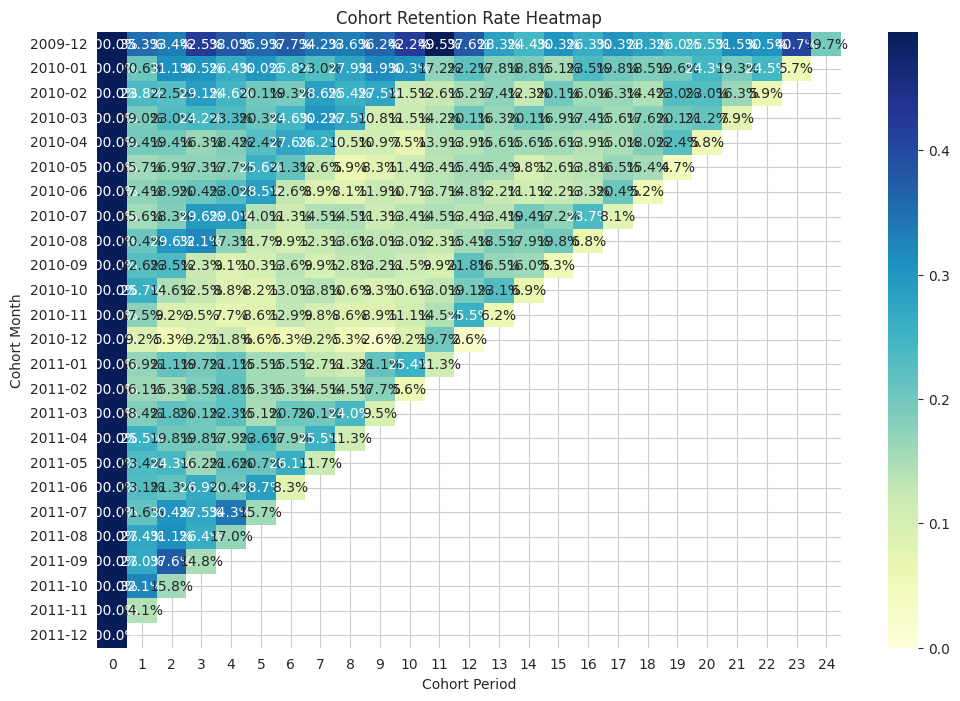

In [30]:
# --- Visualize Cohort Data ---

print("Visualizing Cohort Retention:")

# Create a heatmap
plt.figure(figsize=(12, 8)) # Adjust figure size as needed
sns.heatmap(retention_matrix,
            annot=True, # Show the values on the heatmap
            fmt=".1%", # Format the annotations as percentages
            cmap="YlGnBu", # Choose a color map
            vmin=0.0, # Set minimum value for color scaling
            vmax=retention_matrix.iloc[:, 1:].max().max() # Set max value based on actual data (excluding period 0)
           )
plt.title('Cohort Retention Rate Heatmap')
plt.xlabel('Cohort Period')
plt.ylabel('Cohort Month')
plt.yticks(rotation=0) # Ensure Cohort Month labels are horizontal
plt.show()

# You can create similar heatmaps for other metrics like average spending per customer
# (if you calculated the average_spending_matrix in the previous step)
# plt.figure(figsize=(12, 8))
# sns.heatmap(average_spending_matrix,
#             annot=True,
#             fmt=".2f", # Format as monetary value
#             cmap="YlGnBu"
#            )
# plt.title('Cohort Average Spending Heatmap')
# plt.xlabel('Cohort Period')
# plt.ylabel('Cohort Month')
# plt.yticks(rotation=0)
# plt.show()

In [31]:
import pickle
import os

# Define the directory to save models (create if it doesn't exist)
models_dir = 'models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# --- Save Trained Lifetimes Models ---
try:
    with open(os.path.join(models_dir, 'bgf_model.pkl'), 'wb') as f:
        pickle.dump(bgf, f)
    print("BG/NBD model saved successfully.")

    with open(os.path.join(models_dir, 'ggf_model.pkl'), 'wb') as f:
        pickle.dump(ggf, f)
    print("Gamma-Gamma model saved successfully.")
except Exception as e:
    print(f"An error occurred while saving lifetimes models: {e}")


# --- Save Trained Classification Model (Optional) ---
# Only run this if you trained a classification model (e.g., Logistic Regression)
# Make sure your trained classification model object is named 'model'
# from sklearn.linear_model import LogisticRegression # Example import

# try:
#     if 'model' in locals() and isinstance(model, LogisticRegression): # Check if 'model' exists and is a scikit-learn model
#         with open(os.path.join(models_dir, 'classification_model.pkl'), 'wb') as f:
#             pickle.dump(model, f)
#         print("Classification model saved successfully.")
#     else:
#          print("Classification model object 'model' not found or is not a scikit-learn model. Skipping save.")
# except Exception as e:
#      print(f"An error occurred while saving classification model: {e}")

An error occurred while saving lifetimes models: Can't pickle local object 'BetaGeoFitter.fit.<locals>.<lambda>'


In [32]:
import pickle
import os

# Define the directory to save models (create if it doesn't exist)
models_dir = 'models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# --- Save Trained Lifetimes Model Parameters ---
try:
    # Save BG/NBD model parameters
    bgf_params = bgf.params_
    with open(os.path.join(models_dir, 'bgf_params.pkl'), 'wb') as f:
        pickle.dump(bgf_params, f)
    print("BG/NBD model parameters saved successfully.")

    # Save Gamma-Gamma model parameters
    ggf_params = ggf.params_
    with open(os.path.join(models_dir, 'ggf_params.pkl'), 'wb') as f:
        pickle.dump(ggf_params, f)
    print("Gamma-Gamma model parameters saved successfully.")

except Exception as e:
    print(f"An error occurred while saving lifetimes model parameters: {e}")


# --- Save Trained Classification Model (Optional) ---
# Only run this if you trained a classification model (e.g., Logistic Regression)
# Make sure your trained classification model object is named 'model'
# from sklearn.linear_model import LogisticRegression # Example import

# try:
#     if 'model' in locals() and isinstance(model, LogisticRegression): # Check if 'model' exists and is a scikit-learn model
#         with open(os.path.join(models_dir, 'classification_model.pkl'), 'wb') as f:
#             pickle.dump(model, f)
#         print("Classification model saved successfully.")
#     else:
#          print("Classification model object 'model' not found or is not a scikit-learn model. Skipping save.")
# except Exception as e:
#      print(f"An error occurred while saving classification model: {e}")

BG/NBD model parameters saved successfully.
Gamma-Gamma model parameters saved successfully.
